Good matches: 132 / 4668
Initial affine transform:
 [[ 9.94704559e-01  1.72165407e-03  3.07133296e+01]
 [-1.72165407e-03  9.94704559e-01  2.69665135e+00]]
ECC converged with correlation coefficient: 0.70761


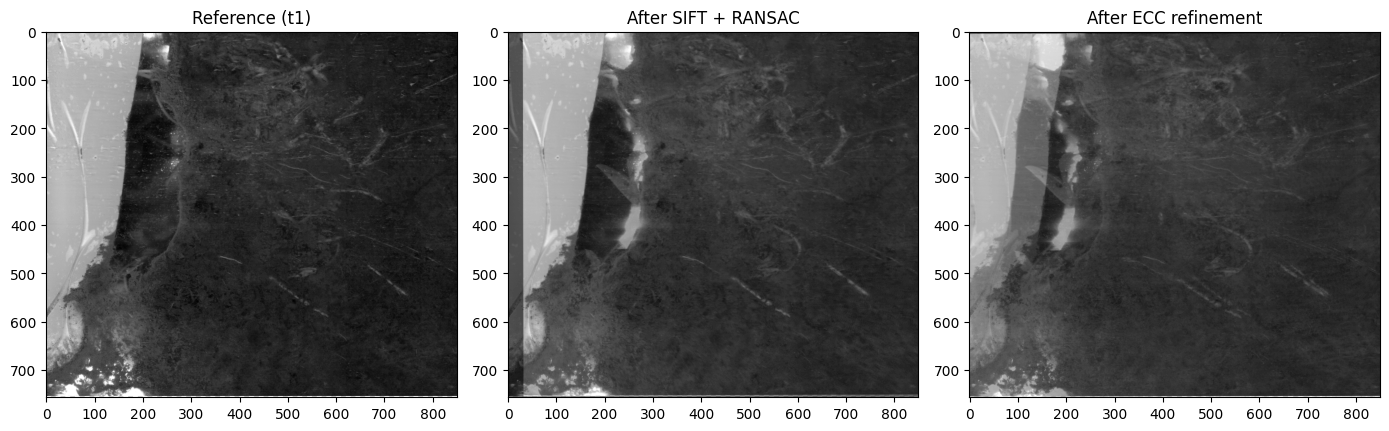

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load or prepare your grayscale images ---
# Replace these paths with your own images
img1 = cv.imread("slu_data/slu_data_201/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)  # reference (earlier)
img2 = cv.imread("slu_data/slu_data_201/kura_201_1_2024-04-22_TP4.png", cv.IMREAD_GRAYSCALE)  # moving (later)

# --- Optional preprocessing (helps feature detection and ECC) ---
def preprocess(img):
    img = cv.GaussianBlur(img, (3, 3), 0)
    img = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img)
    return img

I1, I2 = preprocess(img1), preprocess(img2)

# --- 1. Detect and describe keypoints ---
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1, None)
kp2, des2 = sift.detectAndCompute(I2, None)

# --- 2. Match descriptors (Lowe ratio test) ---
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = [m for m, n in matches if m.distance < 0.75 * n.distance]

print(f"Good matches: {len(good)} / {len(matches)}")

# --- 3. Estimate affine transform via RANSAC ---
if len(good) >= 3:
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    M_affine, inliers = cv.estimateAffinePartial2D(
        pts2, pts1,
        method=cv.RANSAC,
        ransacReprojThreshold=3.0,
        maxIters=2000,
        confidence=0.99
    )

    print("Initial affine transform:\n", M_affine)

    # --- 4. Warp the moving image using the affine transform ---
    aligned_affine = cv.warpAffine(
        img2, M_affine, (img2.shape[1], img2.shape[0]),
        flags=cv.INTER_LINEAR
    )

    # --- 5. ECC refinement (optional fine alignment) ---
    warp_mode = cv.MOTION_AFFINE
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 200, 1e-6)

    # ECC expects float32 images in [0,1]
    I1_f = I1.astype(np.float32) / 255.0
    I2_f = I2.astype(np.float32) / 255.0
    M_refined = M_affine.copy().astype(np.float32)

    try:
        cc, M_refined = cv.findTransformECC(
            I1_f, I2_f, M_refined, warp_mode,
            criteria,
            inputMask=None,  # optionally supply a mask of stable regions
            gaussFiltSize=5
        )
        print(f"ECC converged with correlation coefficient: {cc:.5f}")
    except cv.error as e:
        print("ECC refinement failed:", e)
        M_refined = M_affine

    # --- 6. Final warp after ECC ---
    aligned_final = cv.warpAffine(
        img2, M_refined, (img2.shape[1], img2.shape[0]),
        flags=cv.INTER_LINEAR
    )

    # --- 7. Visualization ---
    overlay_affine = cv.addWeighted(img1, 0.5, aligned_affine, 0.5, 0)
    overlay_final = cv.addWeighted(img1, 0.5, aligned_final, 0.5, 0)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Reference (t1)")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_affine, cmap='gray')
    plt.title("After SIFT + RANSAC")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_final, cmap='gray')
    plt.title("After ECC refinement")
    plt.tight_layout()
    plt.show()

else:
    print("Not enough good matches for reliable affine estimation.")
